In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)


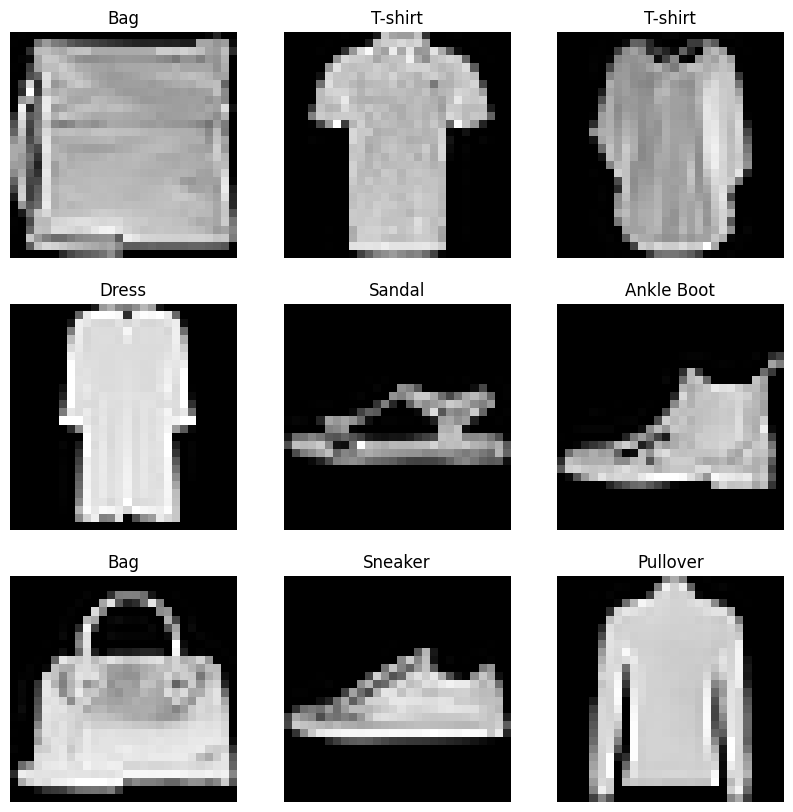

In [8]:
import matplotlib.pyplot as plt

labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(training_data), size = (1,)).item()
    image, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [14]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [ ]:
class NNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        logits = torch.softmax(logits, dim=1)
        return logits

Using cuda device


In [ ]:


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = NNModel().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Using cuda device
Epoch 1
-------------------------------
loss: 2.302071  [    0/60000]
loss: 1.941642  [ 6400/60000]
loss: 1.787884  [12800/60000]
loss: 1.861956  [19200/60000]
loss: 1.660980  [25600/60000]
loss: 1.701447  [32000/60000]
loss: 1.744900  [38400/60000]
loss: 1.684128  [44800/60000]
loss: 1.724518  [51200/60000]
loss: 1.686560  [57600/60000]
Test Error: 
 Accuracy: 79.7%, Avg loss: 1.678060 

Epoch 2
-------------------------------
loss: 1.651818  [    0/60000]
loss: 1.645923  [ 6400/60000]
loss: 1.643629  [12800/60000]
loss: 1.630175  [19200/60000]
loss: 1.571338  [25600/60000]
loss: 1.631035  [32000/60000]
loss: 1.616233  [38400/60000]
loss: 1.683330  [44800/60000]
loss: 1.609404  [51200/60000]
loss: 1.704623  [57600/60000]
Test Error: 
 Accuracy: 82.7%, Avg loss: 1.641740 

Epoch 3
-------------------------------
loss: 1.575116  [    0/60000]
loss: 1.607608  [ 6400/60000]
loss: 1.678230  [12800/60000]
loss: 1.650990  [19200/60000]
loss: 1.626074  [25600/60000]
loss: 1.

In [31]:
jit_model = torch.jit.trace(model, torch.randn(1, 1, 28, 28).to(device))
torch.jit.save(jit_model, "fashion_mnist_model.pth")

In [32]:
model = torch.jit.load("fashion_mnist_model.pth")

In [35]:
model.eval()
x, y = test_data[0][0].to(device), test_data[0][1]
with torch.no_grad():
    pred = model(x.unsqueeze(0))
    predicted, actual = labels_map[pred[0].argmax(0).item()], labels_map[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle Boot", Actual: "Ankle Boot"
